Torch is already installed in Colab - but you can run for fun to check

In [ ]:
#!pip3 install torch

Add the DLH folder in the top-level of your Google Drive
Mount Colab to this location (only run once)

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
os.chdir("drive/My Drive/DLH_Project")

Mounted at /content/drive


In [ ]:
%pwd

'/content/drive/.shortcut-targets-by-id/1vmmLQvXIsZR9fm3bw0w0w0S4STu7QfhY/DLH_Project'

Check that we are in the DLH_Project folder

Load the necessary modules


In [ ]:
import pandas as pd
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from skimage import io, transform
import numpy as np

In [ ]:
IMG_PATH =  '/content/drive/My Drive/DLH_Project/images/'
TRAIN_CSV = '/content/drive/My Drive/DLH_Project/images/MultiLabelTrain.csv'  #input your train.csv file here
VALID_CSV = '/content/drive/My Drive/DLH_Project/images/MultiLabelTest.csv'   #input your valid.csv file here
MAXSAMPLES = 5000

Create custom dataset for loading images from the filepaths specified in the CSV

In [ ]:
from torch.utils.data import Dataset 
from PIL import Image

class PneumoniaDataset(Dataset): 
  def __init__(self, csv_file, root_dir, transform = None): 
    df1 = pd.read_csv(csv_file)  
    df = self.dfFilter(df1, n=MAXSAMPLES) #change MAXSAMPLES if you don't want to use entire dataset
    self.data_file = df
    self.root_dir = root_dir  
    self.transform = transform

  def dfFilter(self, file, n):
    df.fillna(0, inplace=True)            #change all nan to 0
    for i in range(5,19):                 #5,19 denotes labels 1-14
      for j in range(len(df)):            #convert all -1s to 0s
        if df.iloc[j,i] < 0:
          df.iloc[j,i] = 0
    print('n samples = ', len(df))  
    for k in range(5,19):
      print(df.columns[k], '\t\t', df.iloc[:,k].sum(), 'positive labels')
    return df

  def __len__(self):
    return(len(self.data_file))

  def __getitem__(self, idx): 
    path = self.data_file
    img_path = IMG_PATH + self.data_file.iloc[idx, 0]
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = self.transform(image)
    y = self.data_file.iloc[idx, 5:19]  #important!!! change y for multilabel classification
    y = torch.tensor(y, dtype = torch.float32)  #change y to tensor; long is required for loss calculation see https://jdhao.github.io/2017/11/15/pytorch-datatype-note/
    return image, y

In [ ]:
df = pd.read_csv('/content/drive/My Drive/DLH_Project/images/MultiLabelTrain.csv')

In [ ]:
df.head(n=5)

,CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg,Female,68,Frontal,AP,1,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,0,Unnamed: 15,Unnamed: 16,Unnamed: 17,1.1
0,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
1,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
3,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Frontal,PA,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0


Build x-ray dataset
Look at the dataset

Note: We will want to truncate the CSV to only the images we have loaded

In [ ]:
'''
dataset = PneumoniaDataset(csv_file=TRAIN_CSV, root_dir="images/", transform=transforms.ToTensor())  #root_dir not being used since full path is given in TRAIN_CSV
# using the ToTensor transform to grab image shape easily

print(len(dataset))
for i in range(1):
  print(i, dataset[i])
  print(i, "image shape: ", dataset[i][0].size())
'''  

'\ndataset = PneumoniaDataset(csv_file=TRAIN_CSV, root_dir="images/", transform=transforms.ToTensor())  #root_dir not being used since full path is given in TRAIN_CSV\n# using the ToTensor transform to grab image shape easily\n\nprint(len(dataset))\nfor i in range(1):\n  print(i, dataset[i])\n  print(i, "image shape: ", dataset[i][0].size())\n'

Dataloader


In [ ]:
def load_data(csv_filepath, root_dir):
  img_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.RandomResizedCrop(224)
  ])
  train_data = PneumoniaDataset(csv_filepath, root_dir, transform = img_transform) 
  train_loader = torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle = True, num_workers = 2) 
  return train_loader

In [ ]:
train_loader = load_data(TRAIN_CSV, root_dir="images/")  #root_dir not being used since full path is given in TRAIN_CSV

n samples =  2472
1 		 255.0 positive labels
Unnamed: 6 		 108.0 positive labels
Unnamed: 7 		 308.0 positive labels
Unnamed: 8 		 1136.0 positive labels
Unnamed: 9 		 97.0 positive labels
Unnamed: 10 		 570.0 positive labels
Unnamed: 11 		 153.0 positive labels
Unnamed: 12 		 56.0 positive labels
Unnamed: 13 		 352.0 positive labels
0 		 259.0 positive labels
Unnamed: 15 		 970.0 positive labels
Unnamed: 16 		 39.0 positive labels
Unnamed: 17 		 98.0 positive labels
1.1 		 1317.0 positive labels


In [ ]:
#sanity checks
'''
data = iter(train_loader)
data_batch1 = next(data)
print(data_batch1[0].shape)  #shape looks right
print(data_batch1[0][0])  #data of 1st sample (1,224,224)
'''

'\ndata = iter(train_loader)\ndata_batch1 = next(data)\nprint(data_batch1[0].shape)  #shape looks right\nprint(data_batch1[0][0])  #data of 1st sample (1,224,224)\n'

In [ ]:
valid_loader = load_data(VALID_CSV, root_dir="images/")  #root_dir not being used since full path is given in VALID_CSV

n samples =  2472
1 		 255.0 positive labels
Unnamed: 6 		 108.0 positive labels
Unnamed: 7 		 308.0 positive labels
Unnamed: 8 		 1136.0 positive labels
Unnamed: 9 		 97.0 positive labels
Unnamed: 10 		 570.0 positive labels
Unnamed: 11 		 153.0 positive labels
Unnamed: 12 		 56.0 positive labels
Unnamed: 13 		 352.0 positive labels
0 		 259.0 positive labels
Unnamed: 15 		 970.0 positive labels
Unnamed: 16 		 39.0 positive labels
Unnamed: 17 		 98.0 positive labels
1.1 		 1317.0 positive labels


In [ ]:
#sanity checks
'''
data = iter(valid_loader)
data_batch1 = next(data)
print(data_batch1[0].shape)  #shape looks right
print(data_batch1[0][0])  #data of 1st sample (1,224,224)
'''

'\ndata = iter(valid_loader)\ndata_batch1 = next(data)\nprint(data_batch1[0].shape)  #shape looks right\nprint(data_batch1[0][0])  #data of 1st sample (1,224,224)\n'

Example images


n samples =  2472
1 		 255.0 positive labels
Unnamed: 6 		 108.0 positive labels
Unnamed: 7 		 308.0 positive labels
Unnamed: 8 		 1136.0 positive labels
Unnamed: 9 		 97.0 positive labels
Unnamed: 10 		 570.0 positive labels
Unnamed: 11 		 153.0 positive labels
Unnamed: 12 		 56.0 positive labels
Unnamed: 13 		 352.0 positive labels
0 		 259.0 positive labels
Unnamed: 15 		 970.0 positive labels
Unnamed: 16 		 39.0 positive labels
Unnamed: 17 		 98.0 positive labels
1.1 		 1317.0 positive labels


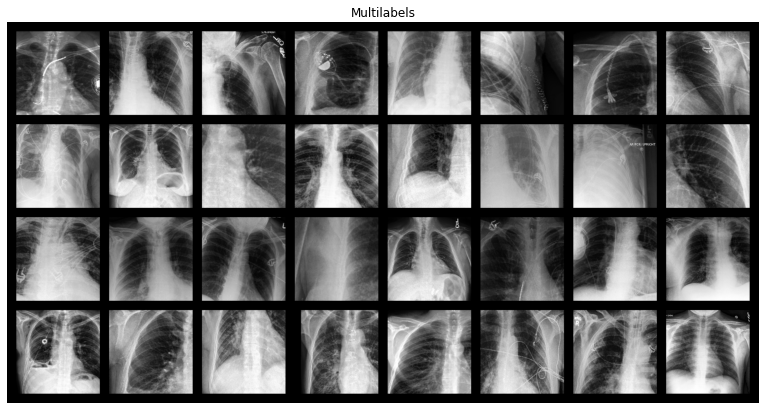

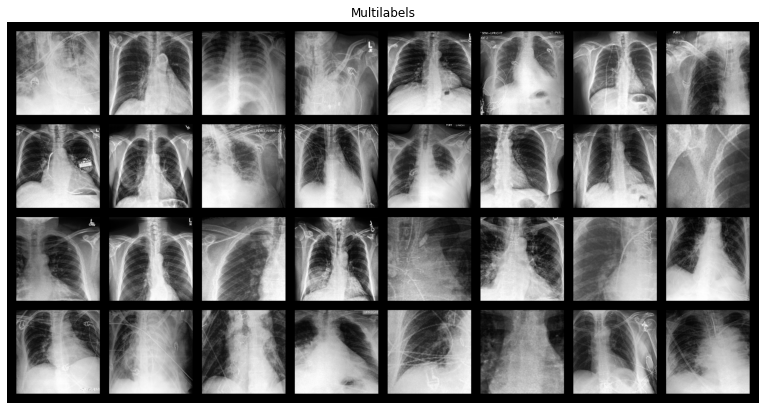

In [ ]:
import numpy as np

def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(15, 7))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images, padding=25)
    #imshow(img, title=["NORMAL" if x==0  else "PNEUMONIA" for x in labels])  #for single label only
    imshow(img, title='Multilabels')
train_loader = load_data(TRAIN_CSV, root_dir="images/")  #root_dir not being used since full path is given in TRAIN_CSV

for i in range(2):
    show_batch_images(train_loader)

In [ ]:
#print(model)

In [ ]:
#output
# model: the cnn model
import torch.nn as nn
import torch.nn.functional as F

def get_resnet_model():
    """
    Define the CNN model here. 
    We will use the pretrained resnet18 model, which can be initialized with torchvision.models.resnet18
    Then, replace the last layer (model.fc) with a nn.Linear layer
    The new model.fc should have the same input size but a new output_size of 14
    """    
    from torchvision import models
    
    num_classes = 14
    model = models.resnet18(pretrained=False)
    
    model.fc = nn.Sequential(
            nn.Linear(model.fc.in_features, 14),
            nn.Sigmoid())
    
    #For computation efficiency, we will freeze the weights in the bottom layers
    #If it's too slow, you can turn off layer4's weights update as well
    for param in model.named_parameters():
        if param[0].split(".")[0] in {'fc', 'layer4'}: continue
        param[1].requires_grad = False

    #print(model.classifier)
    
    return model

In [ ]:
model = get_resnet_model()

In [ ]:
"""
Implement loss function (CrossEntropyLoss) and assign it to `criterion`.
Specify optimizer (SGD) and assign it to `optimizer` aling with the learning rate.
"""
import torch.optim as optim
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
#optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr= 0.001, betas=(0.9,0.999))

In [ ]:

def train_model(model, train_loader, valid_loader, n_epoch, optimizer=optimizer, criterion=criterion):
    import torch.optim as optim
    """
    :param model: A CNN model
    :param train_dataloader: the DataLoader of the training data
    :param n_epoch: number of epochs to train
    :return:
        model: trained model
    """
    model.train() # prep model for training
    
    
    for epoch in range(n_epoch):
        curr_epoch_loss = []
        for data, target in train_loader:
            
            """ Step 1. clear gradients """
            optimizer.zero_grad()
            """ 
            TODO: Step 2. perform forward pass using `model`, save the output to y_hat;
                  Step 3. calculate the loss using `criterion`, save the output to loss.
            """ 
            y_hat = model(data)  #forward pass
            loss = criterion(y_hat, target)  #loss calculation          
            
            """ Step 4. backward pass """
            loss.backward()
            """ Step 5. optimization """
            optimizer.step()   
            
            curr_epoch_loss.append(loss.cpu().data.numpy()) 
        print(f"Epoch {epoch}: curr_epoch_loss={np.mean(curr_epoch_loss)}")
        
    return model


In [ ]:
from sklearn.metrics import *

def classification_metrics02(Y_pred, Y_true):
    #input: both Y_pred (predicted probabilites), Y_true (truth labels) are numpy arrays (n,14) for multilabel classification
    #output: dataframe shape (14, 5) -> 14 labels, 5 metrics 

    Y_pred_prob = Y_pred        
    Y_pred_label = Y_pred > 0.5  #boolean dtype
    Y_true = Y_true > 0          #boolean dtype

    #print(Y_pred_prob)
    #print(Y_pred_label)
    #print(Y_true)

    Y_pred_prob = np.transpose(Y_pred_prob)
    Y_pred_label = np.transpose(Y_pred_label)
    Y_true = np.transpose(Y_true)
    num_labels = Y_true.shape[0]
    results = []
 
    for i in range(num_labels):
      scores = []
      #to prevent auc throwing an error, assign to 'nan' for the condition below:
      if Y_true[i,:].sum() == 0 or Y_true[i,:].sum() == Y_true.shape[1]: 
        auc = np.NAN
      else:
        auc = roc_auc_score(Y_true[i,:], Y_pred_prob[i,:])  

      acc = accuracy_score(Y_true[i,:], Y_pred_label[i,:])
      precision = precision_score(Y_true[i,:], Y_pred_label[i,:], average='binary')
      recall = recall_score(Y_true[i,:], Y_pred_label[i,:], average='binary')
      f1score = f1_score(Y_true[i,:], Y_pred_label[i,:], average='binary')

      scores = [acc, auc, precision, recall, f1score]
      results.append(scores)
    #print(results)
    results = np.array(results)
    metrics_df = pd.DataFrame(results,columns=['accuracy', 'auc', 'precision', 'recall', 'f1'])
    return metrics_df

#input: model, loader
def evaluate02(model, valid_loader):
    model.eval()
    all_y_true = torch.FloatTensor()  #this will accumulate all batches; is it faster to use numpy matrix?
    all_y_hat = torch.FloatTensor()   #this will accumulate all batches
    
    for x, y_val in valid_loader:
        y_hat = model(x) 
        all_y_hat = torch.cat((all_y_hat, y_hat.to('cpu').float()), dim=0)
        all_y_true = torch.cat((all_y_true,  y_val.to('cpu').float()), dim=0) 
    
    all_y_hat = all_y_hat.detach().numpy()
    all_y_true = all_y_true.detach().numpy()
    #print(type(all_y_true))   
    #print(type(all_y_hat))
    metrics = classification_metrics02(all_y_hat, all_y_true)
    print(metrics)
    #print(f"acc: {acc:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, f1: {f1:.3f}")
    return 

In [ ]:
#evaluate(model, valid_loader)

In [ ]:
model = train_model(model, train_loader, valid_loader, n_epoch=40, optimizer=optimizer, criterion=criterion)

Epoch 0: curr_epoch_loss=0.3656058609485626
Epoch 1: curr_epoch_loss=0.3490664064884186
Epoch 2: curr_epoch_loss=0.34487685561180115
Epoch 3: curr_epoch_loss=0.3435462415218353
Epoch 4: curr_epoch_loss=0.3412918448448181
Epoch 5: curr_epoch_loss=0.3421241343021393
Epoch 6: curr_epoch_loss=0.33921587467193604
Epoch 7: curr_epoch_loss=0.34020739793777466
Epoch 8: curr_epoch_loss=0.33735206723213196
Epoch 9: curr_epoch_loss=0.33730050921440125
Epoch 10: curr_epoch_loss=0.3365219831466675
Epoch 11: curr_epoch_loss=0.3363960087299347
Epoch 12: curr_epoch_loss=0.3362673819065094
Epoch 13: curr_epoch_loss=0.3350537121295929
Epoch 14: curr_epoch_loss=0.3320091962814331
Epoch 15: curr_epoch_loss=0.3331604301929474
Epoch 16: curr_epoch_loss=0.33197009563446045
Epoch 17: curr_epoch_loss=0.3320634067058563
Epoch 18: curr_epoch_loss=0.33173754811286926
Epoch 19: curr_epoch_loss=0.32988494634628296
Epoch 20: curr_epoch_loss=0.33069902658462524
Epoch 21: curr_epoch_loss=0.3291221857070923
Epoch 22: c

In [ ]:
#to save your model
torch.save(model.state_dict(), '/content/drive/My Drive/DLH_Project/Colab Notebooks/ar_resnetmodel_multi03.pth')

model_multi00.pth - 01 epochs loss = xxxx  



In [ ]:
#to reload your model
modelmulti00 = get_resnet_model()  #create instance of your chosen model
modelmulti00.load_state_dict(torch.load('/content/drive/My Drive/DLH_Project/Colab Notebooks/ar_resnetmodel_multi03.pth'))


<All keys matched successfully>

In [ ]:
#run evaluate() on your saved model here to get statistics
evaluate02(modelmulti00, valid_loader)

    accuracy       auc  precision    recall        f1
0   0.897249  0.819357   0.666667  0.007843  0.015504
1   0.956311  0.666526   0.000000  0.000000  0.000000
2   0.875809  0.757178   1.000000  0.003247  0.006472
3   0.614482  0.669685   0.565591  0.694542  0.623469
4   0.960761  0.714361   0.000000  0.000000  0.000000
5   0.775081  0.754544   0.533981  0.192982  0.283505
6   0.938107  0.654158   0.000000  0.000000  0.000000
7   0.977346  0.622391   0.000000  0.000000  0.000000
8   0.857605  0.634908   0.000000  0.000000  0.000000
9   0.893204  0.737419   0.477064  0.200772  0.282609
10  0.672735  0.739274   0.570925  0.668041  0.615677
11  0.984223  0.754951   0.000000  0.000000  0.000000
12  0.960356  0.696766   0.000000  0.000000  0.000000
13  0.633900  0.744558   0.601179  0.929385  0.730092


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

In [ ]:
while True: continue